In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import re
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0

## Load ConsensusPathDB Raw Data
**Source: http://cpdb.molgen.mpg.de/download/ConsensusPathDB_human_PPI.gz**  
Downloaded: November 16, 2021  
Last Updated: June 19, 2021
We only downloaded the protein interaction part of this database.  
  
**From the website:**    
"The protein interaction part of the integrated network is available for download. Due to several licensing issues, we are not allowed to release the complete integrated network (including signaling, metabolism and gene regulation).
Rows with one protein only describe self-interactions, and rows with more than two proteins describe complex interactions. In cases when proteins are annotated only with genomic identifiers but no protein identifiers in the according source databases, and if the genomic identifiers map to more than one UniProt entry, the according UniProt entry names are concatenated (e.g. RL40_HUMAN.RS27A_HUMAN.UBIQ_HUMAN) as it is unclear which of the gene products interact."  
  
**Note about processing gene names:**  
The gene names here are all listed as UniProtKB-IDs, however, MyGene.Info does not map these ID names. Therefore, we will use the UniProtKB mapping table (https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz) to convert from the UniProtKB-IDs to the gene name. We will only be using the human mappings. UniProtKB-IDs with Gene Names mapped to the same UniProt Accession number in the first column will be mapped together. Updated version of mapping downloaded November 18, 2021
  
**Note about 'interaction confidence'**
This column could potentially be used to filter interactions, but since we include the co-complex interactions in the list of interactors and these do not have an interaction confidence, we do not consider this scoring for a filtering of ConsensusPathDB

In [3]:
input_raw_v2 = pd.read_csv(wd+'Network_Data_Raw/ConsensusPathDB_human_PPI_v35.tsv',sep='\t',skiprows=1)
print(input_raw_v2.shape[0], 'raw interactions in ConsensusPathDB')

554471 raw interactions in ConsensusPathDB


In [4]:
# Get all interaction from CPDB
input_raw_interactions_v2 = list(input_raw_v2['interaction_participants'])

In [5]:
# Remove self-edges from CPDB interactions
interactions_filt_v2 = []
for interaction in input_raw_interactions_v2:
    interaction_split = re.split(',|\.', interaction)
    if len(interaction_split) > 1:
        interactions_filt_v2.append(interaction_split)

In [7]:
# Extract Binary interactions from lists of interactors (multi-protein complex interactions form cliques)
binary_interactions_v2 = [list(itertools.combinations(gene_list, 2)) for gene_list in interactions_filt_v2]
edgelist_v2 = list(itertools.chain(*binary_interactions_v2))
print('Binary, non-self interactions in ConsensusPathDB v35:', len(edgelist_v2))

Binary, non-self interactions in ConsensusPathDB v35: 10625935


In [8]:
edgelist_sorted_v2 = [sorted(edge) for edge in edgelist_v2]
edgelist_sorted_v2 = pd.DataFrame(edgelist_sorted_v2, columns=["symbol_n1", "symbol_n2"])

## Gene symbol conversion

In [9]:
genes_v2 = (list(set(edgelist_sorted_v2["symbol_n1"]).union(set(edgelist_sorted_v2["symbol_n2"]))))
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2)

20739 Valid Query Genes
0 Invalid Query Genes


In [10]:
# Convert uniprot IDs to Uniprot Accession
uniprot_ids_v2, missing_v2 = gct.query_uniprot(valid_genes_v2, return_as_dict=False, target_fmt="ACC")

In [11]:
# Convert Accessions to symbols
intermediate_genes_v2 = list(uniprot_ids_v2["ACC"].values)
uniprot_mapping_v2, missing_v2 = gct.query_uniprot(intermediate_genes_v2, return_as_dict=False, target_fmt="GENENAME")

In [12]:
uniprot_final_v2 = uniprot_ids_v2.merge(uniprot_mapping_v2, left_on=['ACC', "_score"], right_on=["query", "_score"], how="left",
                                 suffixes=["", "-y"]).loc[:,("query", "symbol", "_score")]

In [14]:
# Make ure symbols are updated to latest uniprot
check_names_v2 = uniprot_final_v2.symbol.values
mapped_v2, unmapped_v2 = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              check_names_v2, return_as_dict=False)

In [15]:
# Get final gene mapping
final_mapping_v2 = uniprot_final_v2.merge(mapped_v2,left_on=["symbol"], right_on=["Query"], how='outer', 
                                    suffixes=["", "-y"]).loc[:, ("query", "Approved symbol", "NCBI Gene ID", "_score")]
final_mapping_v2.columns = ["query", "symbol", "entrezgene", "_score"]

In [16]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(final_mapping_v2, valid_genes_v2)

Number of genes with multiple matches: 132
Number of unmatched genes: 688
Number of fully matched genes: 19936
Number of partially matched genes: 803


In [17]:
edgelist_updated_v2 = gct.convert_edgelist(edgelist_sorted_v2, query_to_symbol_v2)
# Filter edgelist for duplicate nodes and for self-edges
edgelist_filt_v2 = gct.filter_converted_edgelist(edgelist_updated_v2)

10625935 input edges
4582 self-edges removed
42649 edges with un-mapped genes removed
5271449 duplicate edges removed
Edge list filtered: 10.78 seconds
5307255 Edges remaining


In [18]:
# Save CPDB as gene symbol network
gct.write_edgelist(edgelist_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/ConsensusPathDB_Symbol_v35.sif')

Edge list saved: 4.91 seconds


# Version 1 (original)

## Load ConsensusPathDB Raw Data
**Source: http://cpdb.molgen.mpg.de/download/ConsensusPathDB_human_PPI.gz**  
Downloaded: June 15, 2017  
Last Updated: January 11, 2017  
We only downloaded the protein interaction part of this database.  
  
**From the website:**  
"The protein interaction part of the integrated network is available for download. Due to several licensing issues, we are not allowed to release the complete integrated network (including signaling, metabolism and gene regulation).
Rows with one protein only describe self-interactions, and rows with more than two proteins describe complex interactions. In cases when proteins are annotated only with genomic identifiers but no protein identifiers in the according source databases, and if the genomic identifiers map to more than one UniProt entry, the according UniProt entry names are concatenated (e.g. RL40_HUMAN.RS27A_HUMAN.UBIQ_HUMAN) as it is unclear which of the gene products interact."  
  
**Note about processing gene names:**  
The gene names here are all listed as UniProtKB-IDs, however, MyGene.Info does not map these ID names. Therefore, we will use the UniProtKB mapping table (ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz) to convert from the UniProtKB-IDs to the gene name. We will only be using the human mappings. UniProtKB-IDs with Gene Names mapped to the same UniProt Accession number in the first column will be mapped together. 

**Note about 'interaction confidence'**
This column could potentially be used to filter interactions, but since we include the co-complex interactions in the list of interactors and these do not have an interaction confidence, we do not consider this scoring for a filtering of ConsensusPathDB
  
**Note about 2021 update**  
There are slight differences when re-running this processing pipeline (despite identical input data), most likely due to changes in gene/protein identifiers in the mygene.info database

In [19]:
input_raw = pd.read_csv(wd+'Network_Data_Raw/ConsensusPathDB_human_PPI_v32',sep='\t',skiprows=1)
print(input_raw.shape[0], 'raw interactions in ConsensusPathDB')

291415 raw interactions in ConsensusPathDB


In [20]:
# Get all interaction from CPDB
input_raw_interactions = list(input_raw['interaction_participants'])

In [21]:
# Remove self-edges from CPDB interactions
input_raw_filt = []
for interaction in input_raw_interactions:
    interaction_split = re.split(',|\.', interaction)
    if len(interaction_split) > 1:
        input_raw_filt.append(interaction_split)

In [22]:
# Extract Binary interactions from lists of interactors (multi-protein complex interactions form cliques)
binary_interactions = [list(itertools.combinations(gene_list, 2)) for gene_list in input_raw_filt]
edgelist = list(itertools.chain(*binary_interactions))
print('Binary, non-self interactions in ConsensusPathDB v32:', len(edgelist))

Binary, non-self interactions in ConsensusPathDB v32: 2523991


In [23]:
edgelist_sorted = [sorted(edge) for edge in edgelist]
edgelist_sorted = pd.DataFrame(edgelist_sorted, columns=["symbol_n1", "symbol_n2"])

## Gene symbol conversion

In [24]:
genes = (list(set(edgelist_sorted["symbol_n1"]).union(set(edgelist_sorted["symbol_n2"]))))
query_string, valid_genes, invalid_genes = gct.query_constructor(genes)

18838 Valid Query Genes
0 Invalid Query Genes


In [25]:
# Convert uniprot IDs to Uniprot Accession
uniprot_ids, missing = gct.query_uniprot(valid_genes, return_as_dict=False, target_fmt="ACC")

In [26]:
# Convert Accessions to symbols
intermediate_genes = list(uniprot_ids["ACC"].values)
uniprot_mapping, missing = gct.query_uniprot(intermediate_genes, return_as_dict=False, target_fmt="GENENAME")

In [27]:
uniprot_final = uniprot_ids.merge(uniprot_mapping, left_on=['ACC', "_score"], right_on=["query", "_score"], how="left",
                                 suffixes=["", "-y"]).loc[:,("query", "symbol", "_score")]

In [28]:
# Make ure symbols are updated to latest uniprot
check_names = uniprot_final.symbol.values
mapped, unmapped = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              check_names, return_as_dict=False)

In [29]:
# Get final gene mapping
final_mapping = uniprot_final.merge(mapped,left_on=["symbol"], right_on=["Query"], how='outer', 
                                    suffixes=["", "-y"]).loc[:, ("query", "Approved symbol", "NCBI Gene ID", "_score")]
final_mapping.columns = ["query", "symbol", "entrezgene", "_score"]

In [30]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(final_mapping, valid_genes)

Number of genes with multiple matches: 152
Number of unmatched genes: 685
Number of fully matched genes: 18051
Number of partially matched genes: 787


In [31]:
edgelist_updated = gct.convert_edgelist(edgelist_sorted, query_to_symbol)
# Filter edgelist for duplicate nodes and for self-edges
edgelist_filt = gct.filter_converted_edgelist(edgelist_updated)

2523991 input edges
3180 self-edges removed
15741 edges with un-mapped genes removed
821785 duplicate edges removed
Edge list filtered: 2.61 seconds
1683285 Edges remaining


In [32]:
# Save CPDB as gene symbol network
gct.write_edgelist(edgelist_filt, wd+'Processed_Data/Network_SIFs_Symbol/ConsensusPathDB_Symbol_v32.sif')

Edge list saved: 1.54 seconds


# Changes

No human filtering done


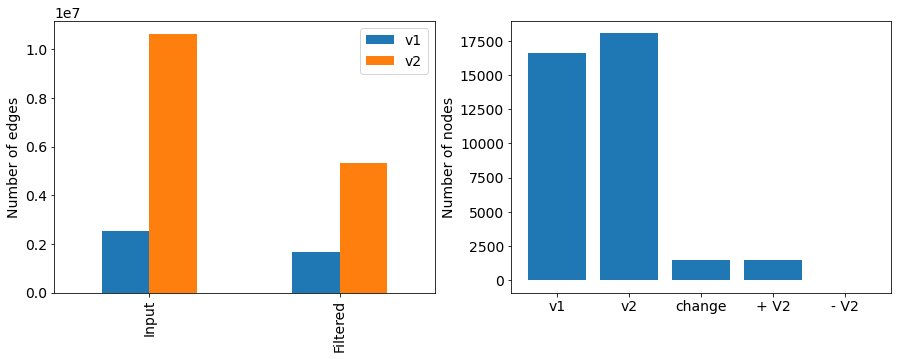

In [35]:
dit.plot_changes_to_dataset(edgelist, edgelist_v2, edgelist_filt, edgelist_filt_v2)